# Question 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def f(t):
    """
    f(t): Takes an argument t, where t is some time variable
    The forcing function of concern for the assignment. In this instance, it is f(t)=sin(t)
    """
    f=np.sin(t)
    return(f)

def exact(t):
    """
    exact(t): Takes an argument t, where t is some time variable.
    Returns the exact solution to the approximated, numerical solution.
    """
    u_e=np.exp(-t)*(0.5*np.sin(2*t)+np.cos(2*t))+(0.2)*np.sin(t)-(0.1)*np.cos(t)
    return(u_e)

def solver(f,I,V,c,w,dt,T):
    """ 
    solver
    f is forcing function
    I is the initial displacement
    V is the initial velocity
    c is the damping coefficient
    w is the angular frequency
    dt is the sampling rate
    T is the total length of time we wish to approximate over
    returns u,t the numerical solution and the time range over which it is approximated.
    """
    dt=float(dt)
    Nt=int(round(T/dt))
    u=np.zeros(Nt+1)
    t=np.linspace(0,Nt*dt,Nt+1)
    u[0]=I
    alpha=(2-dt**2*w**2)/(1+(c/2)*dt)
    beta=(dt**2)/(1+(c/2)*dt)
    gamma=((c/2)*dt-1)/(1+(c/2)*dt)
    u[1]=(alpha*u[0]-gamma*2*dt*V+beta*f(t[0]))/(1-gamma)
    for j in range(1,Nt):
        u[j+1]=((2-dt**2*w**2)*u[j]+((c/2)*dt-1)*u[j-1]+(dt**2)*f(t[j]))/(1+(c/2)*dt)
    return(u,t)

In [151]:
def convergence_rates(m: int,solver: callable,num_periods=8):
    """
    Tests the convergence rates of the solver function.
    Solver function is attuned the vibrational ODE

    Parameters
    ----------
    m : int
    solver : function

    Returns
    ----------
    r : np.array of length m

    E_values : float list of length m

    dt_values : float list of length m

    Examples
    -----------
    >>> convergence_rates(6, solver)
    
    

    """
    from math import pi
    I=9/10
    V=1/5
    c=2
    w=np.sqrt(5)    
    dt=0.5
    T=20    
    dt=0.5
    dt_values=[]
    E_values=[]
    for i in range(m):
        u, t=solver(f,I,V,c,w,dt,T)
        u_e=exact(t)
        E=np.sqrt(dt*np.sum((u_e-u)**2))
        dt_values.append(dt)
        E_values.append(E)
        dt /= 2
    r=[np.log(E_values[i-1]/E_values[i])/np.log(dt_values[i-1]/dt_values[i]) for i in range(1,m,1)]
    return(r, E_values, dt_values)

In [11]:
r,E_values,dt_values=convergence_rates(7,solver)

In [12]:
print(f"This are the r values: {r}\n")
print(f"These are the E values: {E_values}\n")
print(f"These are the dt_values: {dt_values}\n")

This are the r values: [2.1598011263188956, 2.0332081968178257, 2.007984978060593, 2.0019800466839026, 2.0004952425954734, 2.0001244376906775]

These are the E values: [0.1981112853009525, 0.04433475286275465, 0.010831475887036944, 0.0026929229527755945, 0.0006723073871704755, 0.0001680191599453112, 4.200116707677403e-05]

These are the dt_values: [0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125]



# Question 3a

In [152]:
def wave_solver(I,V,f,c: float,L: float,dt: float,dx: float,T: float):
    """
    Solves the 1D elasto-dynamic wave equation utt=c**2*uxx+f(t[n],x[i])

    Parameters
    ----------
    I (initial displacement) : function
    V (initial velocity): function
    f(forcing function) : function
    c (wave speed): float
    L (length of string): float
    dt (sampling rate): float
    dx (sampling length): float
    T (length of time): float

    Returns
    ----------
    u_in : 2D np.array of m(space Nx)xn(time Nt)

    x : np.array of length with Nx grid points

    t : np.array of length with Nt grid points

    cpu_time : float of cpu clock time

    Examples
    -----------
    >>> wave_solver(I,V,F,c,L,dt,dx,T)
    """
    Nt=int(round(T/dt))
    t=np.linspace(0,Nt*dt,Nt+1)
    
    Nx=int(round(L/dx))
    x=np.linspace(0,L,Nx+1)
    C=c*(dt/dx)
    C2=C**2
    dx=x[1]-x[0]
    dt=t[1]-t[0]
    if f is None or f==0:
        f=lambda x,t : 0
    if V is None or V==0 :
        V=lambda x : 0
    u=np.zeros(Nx+1)
    u_in=np.zeros((Nx+1,Nt+1))
    u_n=np.zeros(Nx+1)
    u_nm1=np.zeros(Nx+1)
    import time
    t0=time.process_time()
    for i in range(0,Nx+1):
        u_n[i]=I(x[i])
    n=0
    for i in range(1,Nx):
        u[i]=u_n[i]+dt*V(x[i])+0.5*C2*(u_n[i+1]-2*u_n[i]+u_n[i-1])+0.5*dt**2*f(x[i],t[n],c)
    u[0]=0
    u[Nx]=0
    u_in[:,0]=u[:]
    u_nm1[:]=u_n
    u_n[:]=u
    for n in range(1,Nt+1):
        for i in range(1,Nx):
            u[i]=-u_nm1[i]+2*u_n[i]+C2*(u_n[i+1]-2*u_n[i]+u_n[i-1])+dt**2*f(x[i],t[n],c)
        u[0]=0
        u[Nx]=0
        u_in[:,n]=u[:]
        u_nm1[:]=u_n
        u_n[:]=u
    cpu_time=time.process_time()-t0
    return(u_in,x,t,cpu_time)

# Question 3b

In [149]:
def F(x,t,c):
    """
    Forcing function f(x[i],t[n])

    Parameters
    ----------
    t : float
    x : float

    Returns
    ----------
    float

    Examples
    -----------
    >>> F(x[i],t[n],c)
    """
    return(0.825*np.sin(t)*np.sin(np.pi*x)*(1+c**2*np.pi**2))
def I(x):
    return(0)
def V(x):
    """
    Velocity initial condition

    Parameters
    ----------

    x : float

    Returns
    ----------
    float

    Examples
    -----------
    >>> V(x[n])
    """
    return(1.0*np.sin(np.pi*x))


In [148]:
dt=0.01
dx=0.05
c=1
T=4
L=1

u_in,x,t,cpu_time=wave_solver(I,V,F,c,L,dt,dx,T)
print(cpu_time)

0.033961000000005015


[(0.0, 4.0),
 (0.0, 1.0),
 (-1.0, 1.0),
 Text(0.5, 0, 'T'),
 Text(0.5, 0.5, 'X'),
 Text(0.5, 0, 'U'),
 Text(0.5, 0.92, 'exact')]

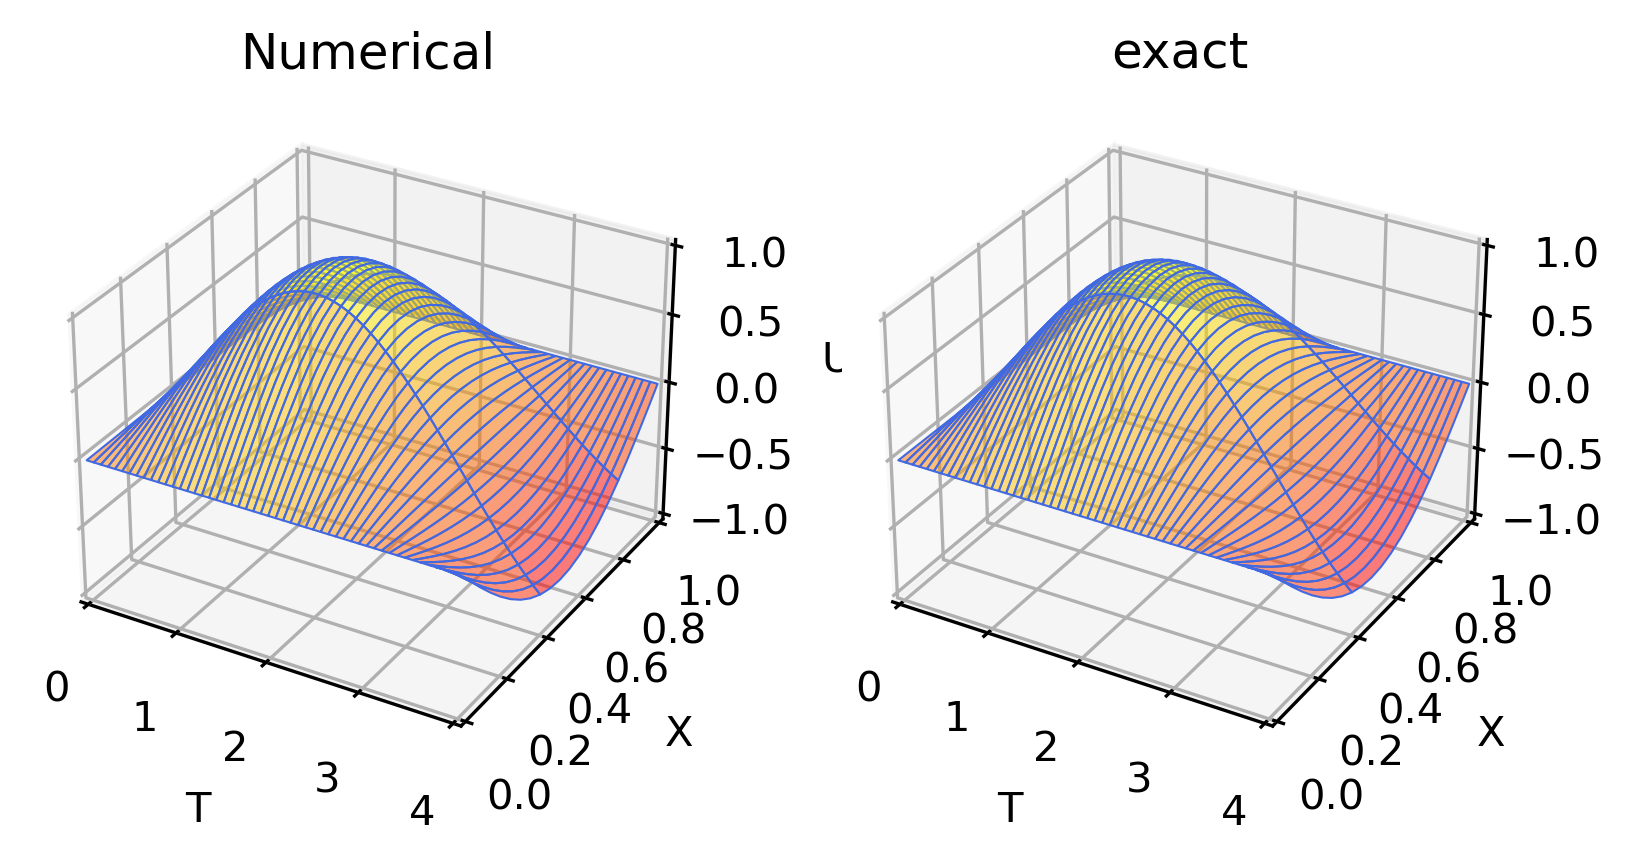

In [153]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
(TT,XX)=np.meshgrid(t,x)
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': '3d'},dpi=300)
axs[0].plot_surface(TT, XX, u_in, cmap='autumn', edgecolor='royalblue',lw=0.5, rstride=8, cstride=8,
                alpha=0.5)
axs[0].set(xlim=(0, 4), ylim=(0, 1), zlim=(-1, 1),
       xlabel='T', ylabel='X', zlabel='U',title='Numerical')
axs[1].plot_surface(TT, XX, np.sin(TT)*np.sin(np.pi*XX), cmap='autumn', edgecolor='royalblue',lw=0.5, rstride=8, cstride=8,
                alpha=0.5)
axs[1].set(xlim=(0, 4), ylim=(0, 1), zlim=(-1, 1),
       xlabel='T', ylabel='X', zlabel='U',title='exact')
